In [1]:
%pip install networkx
%pip install numpy
%pip install matplotlib
%pip install torch
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import csv
from matplotlib.colors import Normalize
import torch.nn as nn
import torch.nn.functional as F


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
def load_accuracies_from_csv(filepath):
    data = []
    with open(filepath, mode='r', newline='') as file:
        reader = csv.DictReader(file)
        for row in reader:
            hidden_dim = int(row['hidden_dim'])
            temp = row.get('temperature', 'N/A')
            temperature = None if temp == 'N/A' else float(temp)
            accuracy = float(row['accuracy'])
            data.append({
                'Hidden Dimension': hidden_dim,
                'Temperature': temperature,
                'Accuracy': accuracy
            })
    return data

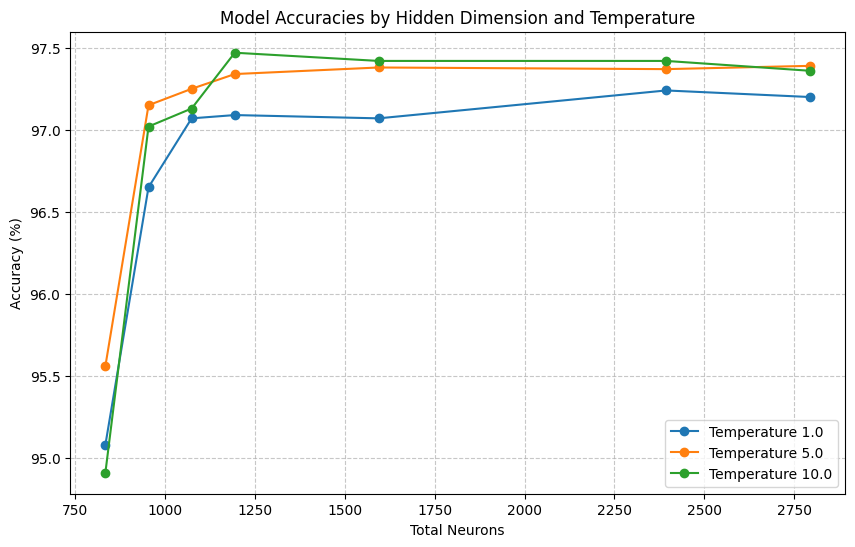

In [10]:

def plot_performance(data):
    #optional: filter out certain dimensions
    # data = [d for d in data if d['Hidden Dimension'] != 20 and d['Hidden Dimension'] != 80]

    plt.figure(figsize=(10, 6))
    hidden_dims = sorted(set(d['Hidden Dimension'] for d in data))
    temperatures = sorted(set(d['Temperature'] for d in data if d['Temperature'] is not None))
    
    for temp in temperatures:
        temp_data = [d for d in data if d['Temperature'] == temp]
        if temp_data:
            dims = [d['Hidden Dimension'] for d in temp_data]
            accs = [d['Accuracy'] for d in temp_data]
            plt.plot(dims, accs, 'o-', label=f'Temperature {temp}')
    
    
    plt.xlabel('Hidden Dimension')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracies by Hidden Dimension and Temperature')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

data = load_accuracies_from_csv("./model_accuracies_20241109_143903.csv")
plot_performance(data)

[{'Model': 'Teacher', 'Hidden Dimension': 100, 'Temperature': None, 'Accuracy': 97.23}, {'Model': 'Student', 'Hidden Dimension': 100, 'Temperature': 0.001, 'Accuracy': 96.95}, {'Model': 'Student', 'Hidden Dimension': 100, 'Temperature': 0.001, 'Accuracy': 97.34}, {'Model': 'Student', 'Hidden Dimension': 200, 'Temperature': 0.001, 'Accuracy': 97.1}, {'Model': 'Student', 'Hidden Dimension': 200, 'Temperature': 0.001, 'Accuracy': 97.45}, {'Model': 'Teacher', 'Hidden Dimension': 200, 'Temperature': None, 'Accuracy': 97.23}, {'Model': 'Student', 'Hidden Dimension': 100, 'Temperature': 0.001, 'Accuracy': 96.69}, {'Model': 'Student', 'Hidden Dimension': 100, 'Temperature': 0.001, 'Accuracy': 97.25}, {'Model': 'Student', 'Hidden Dimension': 200, 'Temperature': 0.001, 'Accuracy': 97.22}, {'Model': 'Student', 'Hidden Dimension': 200, 'Temperature': 0.001, 'Accuracy': 97.36}]


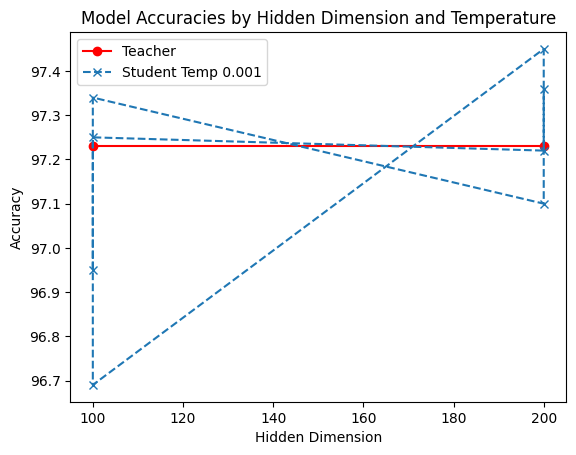

In [4]:
data = load_accuracies_from_csv("./pruning_accuracies.csv")
print(data)
plot_performance(data)

In [5]:
import torch
import torch.nn as nn
class StudentNet(nn.Module):
    def __init__(self, hidden_dim):
        super(StudentNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
class Net(nn.Module):
    def __init__(self, input_dim=28 * 28, hidden_dims=[1200, 1200], output_dim=10):
        super(Net, self).__init__()
        self.fc_layers = nn.ModuleList()
        previous_dim = input_dim
        for h_dim in hidden_dims:
            self.fc_layers.append(nn.Linear(previous_dim, h_dim))
            previous_dim = h_dim
        self.output_layer = nn.Linear(previous_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        for fc in self.fc_layers:
            x = F.relu(fc(x))
        x = self.output_layer(x)
        return x

In [6]:
def plot_network_weights(model_path):
    import torch
    import torch.nn as nn
    import networkx as nx
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    import torch.nn.functional as F

    # Define the model class as per pruning.py
    class Net(nn.Module):
        def __init__(self, input_dim=28 * 28, hidden_dims=[1200, 1200], output_dim=10):
            super(Net, self).__init__()
            self.fc_layers = nn.ModuleList()
            previous_dim = input_dim
            for h_dim in hidden_dims:
                self.fc_layers.append(nn.Linear(previous_dim, h_dim))
                previous_dim = h_dim
            self.output_layer = nn.Linear(previous_dim, output_dim)

        def forward(self, x):
            x = x.view(-1, 28 * 28)
            for fc in self.fc_layers:
                x = F.relu(fc(x))
            x = self.output_layer(x)
            return x

    # Initialize the model with the correct architecture
    model = Net(hidden_dims=[200, 200])

    # Load the state_dict into the model
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    G = nx.DiGraph()

    # Build the graph from the model's layers
    layers = []

    # Extract layers from fc_layers
    for idx, layer in enumerate(model.fc_layers):
        if isinstance(layer, nn.Linear):
            layers.append((f"fc_layers.{idx}", layer))
    
    # Add the output layer
    layers.append(("output_layer", model.output_layer))

    # Build nodes and edges
    layer_num = 0
    for name, layer in layers:
        if isinstance(layer, nn.Linear):
            weights = layer.weight.data.cpu().numpy()
            input_size, output_size = weights.shape
            source_nodes = [f"Layer {layer_num} Node {i}" for i in range(input_size)]
            target_nodes = [f"Layer {layer_num + 1} Node {i}" for i in range(output_size)]
            
            # Add nodes
            G.add_nodes_from(source_nodes)
            G.add_nodes_from(target_nodes)
            
            # Add edges with weights
            for i, source in enumerate(source_nodes):
                for j, target in enumerate(target_nodes):
                    weight = weights[i, j]
                    G.add_edge(source, target, weight=abs(weight))
            
            layer_num += 1  # Increment layer number

    # Visualize the graph
    pos = nx.spring_layout(G, seed=42)
    edges = G.edges(data=True)
    edge_weights = [d['weight'] for (_, _, d) in edges]

    # Normalize weights for color mapping
    norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    edge_colors = [plt.cm.binary(norm(w)) for w in edge_weights]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=False)
    nx.draw_networkx_labels(G, pos, font_size=8)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.binary, norm=norm)
    sm.set_array(edge_weights)
    cbar = plt.colorbar(sm)
    cbar.set_label('Weight Magnitude', rotation=270, labelpad=15)

    plt.title(f"Network Weight Density for {model_path}")
    plt.axis('off')
    plt.show()

In [41]:
def plot_network_weights(model_path):
    """Plots the density of network weights, in the structure of its architecture"""
    import torch
    import torch.nn as nn
    import networkx as nx
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    import torch.nn.functional as F

    # Define the model class as per pruning.py
    class Net(nn.Module):
        def __init__(self, input_dim=28 * 28, hidden_dims=[1200, 1200], output_dim=10):
            super(Net, self).__init__()
            self.fc_layers = nn.ModuleList()
            previous_dim = input_dim
            for h_dim in hidden_dims:
                self.fc_layers.append(nn.Linear(previous_dim, h_dim))
                previous_dim = h_dim
            self.output_layer = nn.Linear(previous_dim, output_dim)

        def forward(self, x):
            x = x.view(-1, 28 * 28)
            for fc in self.fc_layers:
                x = F.relu(fc(x))
            x = self.output_layer(x)
            return x

    # Initialize the model with the correct architecture
    model = Net(hidden_dims=[200, 200])

    # Load the state_dict into the model
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    # create directed graph
    G = nx.DiGraph()

    # Extract layers
    layers = []
    for idx, layer in enumerate(model.fc_layers):
        if isinstance(layer, nn.Linear):
            layers.append((f"fc_layers.{idx}", layer))
    layers.append(("output_layer", model.output_layer))

    # Build nodes and edges
    layer_num = 0
    for _, layer in layers:
        if isinstance(layer, nn.Linear):
            weights = layer.weight.data.cpu().numpy()
            output_size, input_size = weights.shape
            source_nodes = [f"Layer {layer_num} Node {i}" for i in range(input_size)]
            target_nodes = [f"Layer {layer_num + 1} Node {i}" for i in range(output_size)]
            # Add nodes
            G.add_nodes_from(source_nodes)
            G.add_nodes_from(target_nodes)
            
            # Add edges with weights
            for i, source in enumerate(source_nodes):
                for j, target in enumerate(target_nodes):
                    weight = weights[j, i]
                    G.add_edge(source, target, weight=abs(weight))
            
            layer_num += 1


    # Create a custom layout to reflect the neural network structure
    pos = {}
    layer_sizes = [model.fc_layers[0].in_features] + [layer.out_features for layer in model.fc_layers] + [model.output_layer.out_features]
    y_offset = 0
    for layer_idx, layer_size in enumerate(layer_sizes):
        x_offset = 0
        print(layer_size)
        for node_idx in range(layer_size):
            pos[f"Layer {layer_idx} Node {node_idx}"] = (x_offset, y_offset)
            x_offset += 1
        y_offset -= 1

    # Print the number of positions assigned
    print(f"Total positions assigned: {len(pos)}")

    not_assigned = 0
    for node in G.nodes():
        if node not in pos:
            not_assigned += 1
            pos[node] = (0, 0)  # Default position if not assigned
    print(f"Nodes not assigned: {not_assigned}")

    edges = G.edges(data=True)
    edge_weights = [d['weight'] for (_, _, d) in edges]

    # Normalize weights for color mapping
    norm = Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
    edge_colors = [plt.cm.binary(norm(w)) for w in edge_weights]

    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=False)
    # nx.draw_networkx_labels(G, pos, font_size=8)  # This line is removed to hide node labels

    sm = plt.cm.ScalarMappable(cmap=plt.cm.binary, norm=norm)
    sm.set_array(edge_weights)
    # cbar = plt.colorbar(sm)
    # cbar.set_label('Weight Magnitude', rotation=270, labelpad=15)

    plt.title(f"Network Weight Density for {model_path}")
    plt.axis('off')
    plt.show()

/tmp/ipykernel_2357112/2844711205.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


784
200
200
10
Total positions assigned: 1194
Nodes not assigned: 0


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

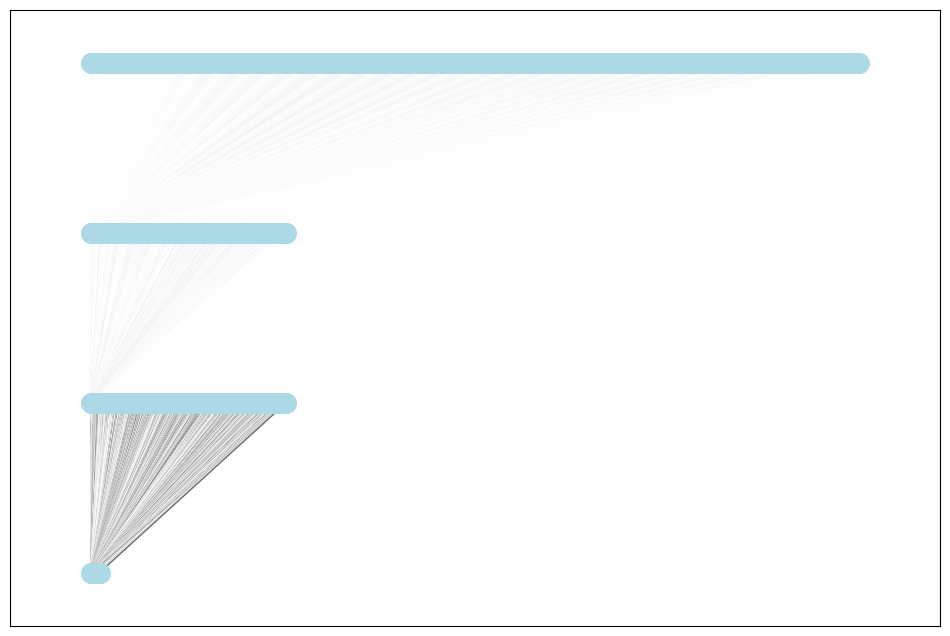

In [42]:
# Visualize the student model weights
plot_network_weights('models/student_hidden200_beta0.001.pth')


/tmp/ipykernel_2357112/2844711205.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


784
200
200
10
Total positions assigned: 1194
Nodes not assigned: 0


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

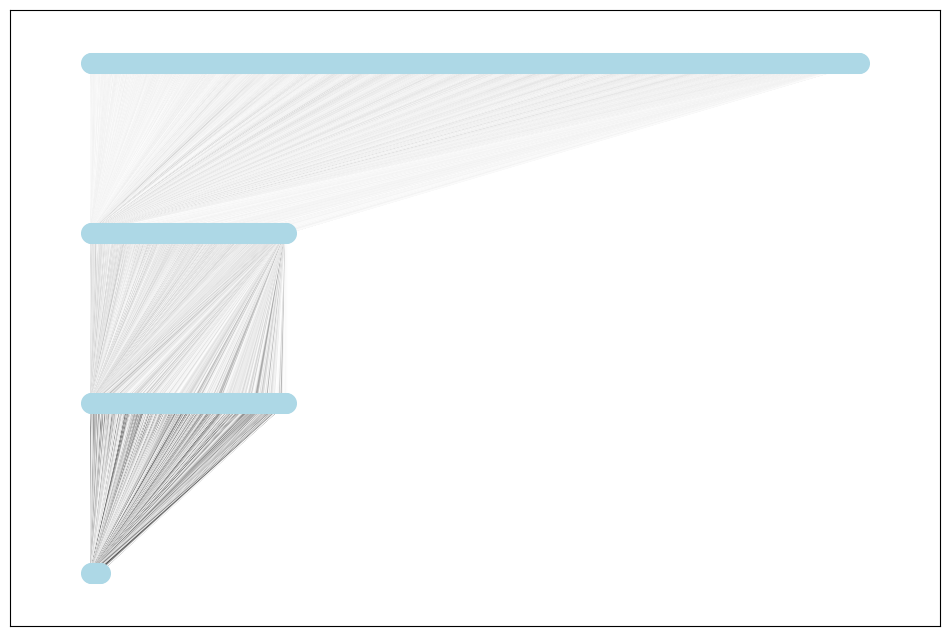

In [48]:
# Visualize the teacher model weights
plot_network_weights('models/teacher_hidden200.pth')

In [46]:
import torch
import matplotlib.pyplot as plt

def plot_weight_distributions(model_path):

    # Define the model class as per pruning.py
    class Net(nn.Module):
        def __init__(self, input_dim=28 * 28, hidden_dims=[1200, 1200], output_dim=10):
            super(Net, self).__init__()
            self.fc_layers = nn.ModuleList()
            previous_dim = input_dim
            for h_dim in hidden_dims:
                self.fc_layers.append(nn.Linear(previous_dim, h_dim))
                previous_dim = h_dim
            self.output_layer = nn.Linear(previous_dim, output_dim)

        def forward(self, x):
            x = x.view(-1, 28 * 28)
            for fc in self.fc_layers:
                x = F.relu(fc(x))
            x = self.output_layer(x)
            return x

    # Initialize the model with the correct architecture
    model = Net(hidden_dims=[200, 200])

    # Load the state_dict into the model
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    """Plots histograms of the weight distributions for each layer in the model."""
    for i, layer in enumerate(model.fc_layers):
        weights = layer.weight.data.cpu().numpy().flatten()
        plt.figure(figsize=(8, 4))
        plt.hist(weights, bins=50, alpha=0.7, color='blue')
        plt.title(f'Layer {i} Weight Distribution')
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

    # Plot for the output layer
    output_weights = model.output_layer.weight.data.cpu().numpy().flatten()
    plt.figure(figsize=(8, 4))
    plt.hist(output_weights, bins=50, alpha=0.7, color='green')
    plt.title('Output Layer Weight Distribution')
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


/tmp/ipykernel_2357112/1895955806.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


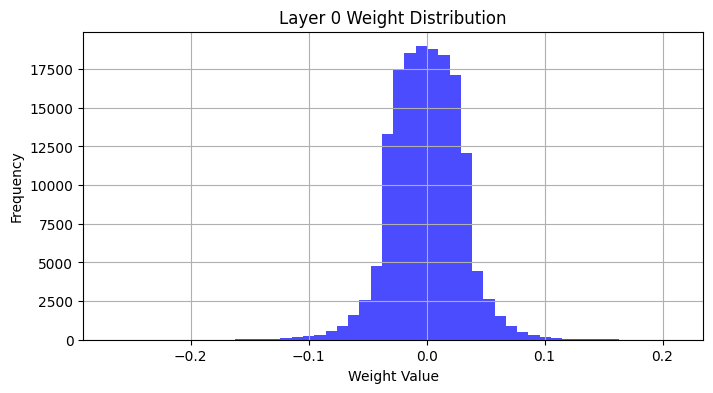

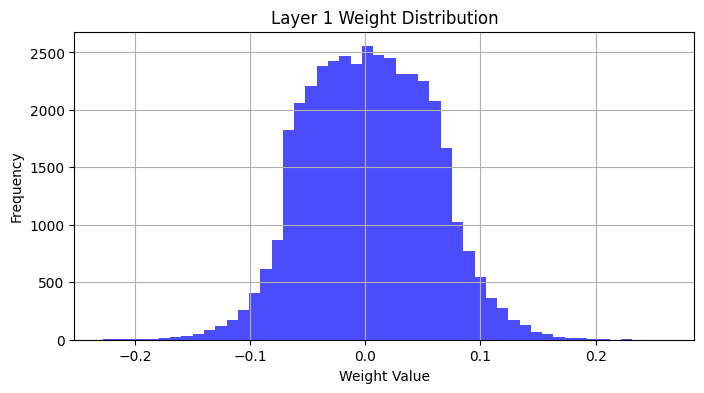

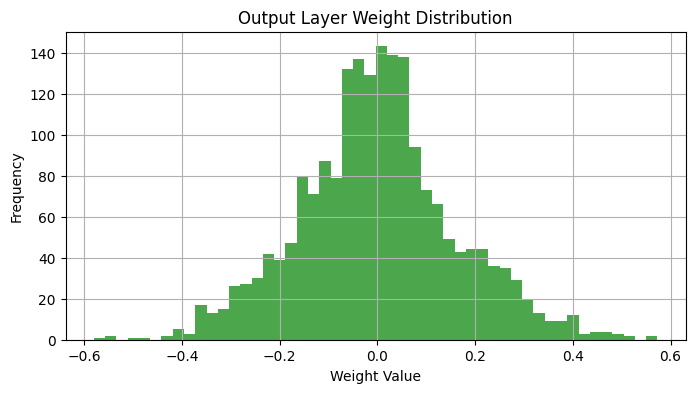

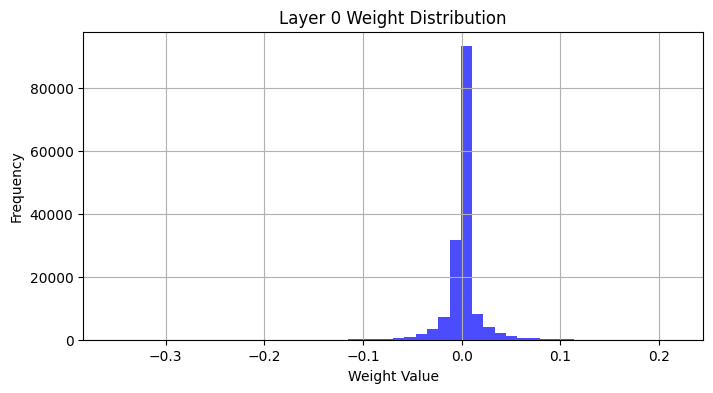

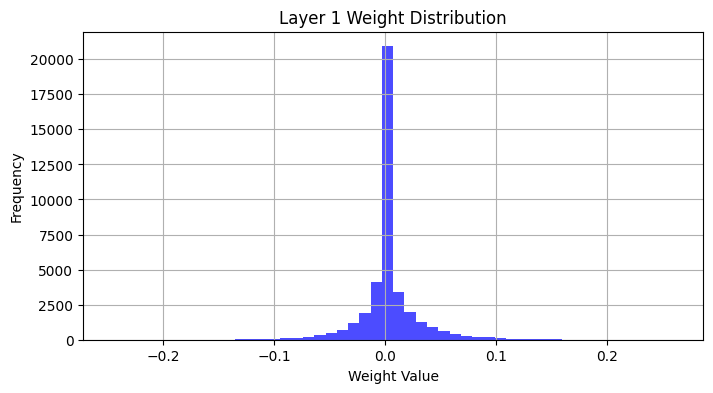

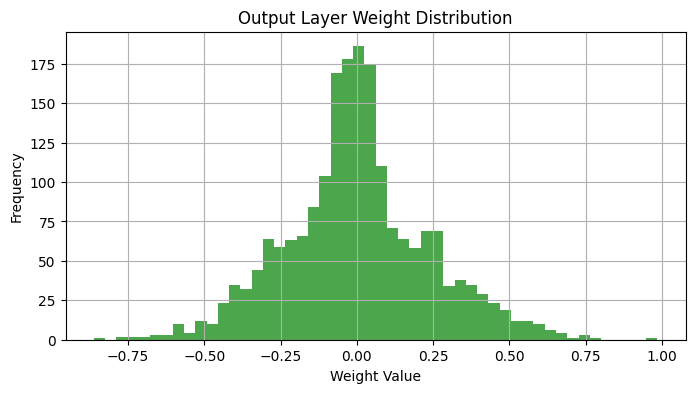

In [47]:
plot_weight_distributions('models/teacher_hidden200.pth')
plot_weight_distributions("models/student_hidden200_beta0.001.pth")